# 4. Estrategia de Modelado y Evaluación de Impacto

## Resumen Ejecutivo
Finalizada la preparación de datos, iniciamos la fase de modelado predictivo. El objetivo no es solo ajustar un algoritmo, sino maximizar la **captura de valor** para la aseguradora. Dado el desbalance de clases, el éxito se medirá por la capacidad del modelo para predecir los reclamos reales dentro de los segmentos de mayor probabilidad, optimizando así los recursos de inspección o prevención.

## Arquitectura de la Competencia
Se ha diseñado un esquema de evaluación comparativa (*Benchmark*) entre tres familias de algoritmos para determinar cuál ofrece la mejor generalización:

1.  **Random Forest (Bagging)**
2.  **XGBoost (Gradient Boosting)**
3.  **LightGBM (Leaf-wise Boosting)**

## Definición de KPIs (Alineación con el Negocio)
Siguiendo los criterios definidos en la fase de *Business Understanding*, los modelos serán juzgados estrictamente bajo las siguientes métricas:

* **AUC-ROC (Discriminación):** Debe superar el 0.75 para considerar que el modelo tiene capacidad predictiva real.
* **Recall (Sensibilidad):** Debe superar el 60% en la clase positiva (reclamos).
* **Lift @ Top 10% (Eficiencia Operativa):** Lift > 3.0 indica que el modelo triplica la eficiencia del azar en el segmento prioritario.

---

In [1]:
# imports
import os
from pathlib import Path

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb

# Models
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

In [2]:
# Routes
DATA_PATH = Path("../data")
CLEANED_DATA_PATH = DATA_PATH / "cleaned"

In [3]:
# Load dataset
try:
    df = pd.read_csv(CLEANED_DATA_PATH / "cleaned_train_folds.csv", sep=",")
    print(f"Dataset loaded successfully. Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error! The file does not exist. Check the path.")
X = df.drop(["claim_status", "kfold"], axis=1)
y = df["claim_status"]
# Initial overview
df.head()

Dataset loaded successfully. Dimensions: (45358, 25)


,segment,subscription_length,vehicle_age,power_bhp,torque_nm,region_density,is_adjustable_steering,is_parking_sensors,is_brake_assist,claim_status,...,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,rear_brakes_type_Drum,transmission_type_Manual
0,4,0.407143,0.01,0.937051,1.000000,0.116270,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0.050000,0.00,0.000000,0.000000,1.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,4,0.271429,0.08,0.937051,1.000000,0.079601,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0.078571,0.07,0.937051,1.000000,0.116270,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,2,0.721429,0.02,0.617179,0.278947,0.116270,1,1,1,0,...,0,0,0,0,1,0,0,0,1,1


In [4]:
# lift function
def calculate_lift(y_true, y_proba, percentile=10):
    """
    Calculate the lift at a given percentile.
    Formula: Lift = (Target Rate in Top X%) / (Overall Target Rate)
    """
    data = pd.DataFrame({"y_true": y_true, "proba": y_proba})
    data = data.sort_values("proba", ascending=False)

    cut_off = int(len(data) * (percentile / 100))

    top_data = data.iloc[:cut_off]

    target_rate_top = top_data["y_true"].mean()
    target_rate_global = data["y_true"].mean()

    if target_rate_global == 0:
        return 0

    return target_rate_top / target_rate_global

In [ ]:
def train_evaluate_model(
    model, df, features, model_name="Model", fold_col="kfold", callbacks=None
):
    """
    Train and evaluate the model using K-Fold CV.
    Returns average metrics and OOF predictions.
    Metrics: AUC, Recall, Lift@10.
    """
    oof_preds = np.zeros(len(df))

    # 5-Fold CV loop
    for fold in range(5):
        train_idx = df[fold_col] != fold
        val_idx = df[fold_col] == fold

        # Split
        X_train, y_train = (
            df.loc[train_idx, features],
            df.loc[train_idx, "claim_status"],
        )
        X_val, _ = df.loc[val_idx, features], df.loc[val_idx, "claim_status"]

        # train
        model.fit(X_train, y_train)

        val_probs = model.predict_proba(X_val)[:, 1]

        # save OOF
        oof_preds[val_idx] = val_probs

    return oof_preds

In [6]:
def run_baseline_analysis(model, df, features, model_name, callbacks=None):
    """
    1. Train model.
    2. Print numerical metrics.
    3. Plot the accumulated Confusion Matrix.
    4. Print error diagnosis.
    """

    # Train and Evaluate
    oof_preds = train_evaluate_model(
        model,
        df,
        features,
        model_name=model_name,
        fold_col="kfold",
        callbacks=callbacks,
    )

    # Calculate Metrics
    auc = roc_auc_score(y, oof_preds)
    lift = calculate_lift(y, oof_preds, percentile=10)
    y_pred_class = (oof_preds >= 0.5).astype(int)
    print(classification_report(y, y_pred_class, zero_division=0))
    print(f"{model_name} - AUC: {auc:.4f}, Lift@10: {lift:.4f}")

    # Prepare Confusion Matrix
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate confusion matrix
    cm = confusion_matrix(y, y_pred_class)
    # Heatmap with annotations
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax[0],
        annot_kws={"size": 14},
    )
    ax[0].set_title("Confusion Matrix - Baseline", fontsize=14, fontweight="bold")
    ax[0].set_xlabel("Predicted Label", fontsize=12)
    ax[0].set_ylabel("True Label", fontsize=12)
    ax[0].set_xticklabels(["No Claim (0)", "Claim (1)"])
    ax[0].set_yticklabels(["No Claim (0)", "Claim (1)"])

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y, oof_preds)

    # Plot
    ax[1].plot(
        fpr, tpr, linestyle="--", color="navy", label=f"Baseline (AUC = {auc:.2f})"
    )
    ax[1].plot(
        [0, 1], [0, 1], color="gray", linestyle="-", alpha=0.5, label="Random Guess"
    )

    ax[1].set_title("ROC Curve - Baseline", fontsize=14, fontweight="bold")
    ax[1].set_xlabel("False Positive Rate", fontsize=12)
    ax[1].set_ylabel("True Positive Rate (Recall)", fontsize=12)
    ax[1].legend(loc="lower right")
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return oof_preds

              precision    recall  f1-score   support

           0       0.95      0.65      0.77     42371
           1       0.10      0.55      0.17      2987

    accuracy                           0.64     45358
   macro avg       0.53      0.60      0.47     45358
weighted avg       0.90      0.64      0.73     45358

Random Forest Baseline - AUC: 0.6385, Lift@10: 1.8483


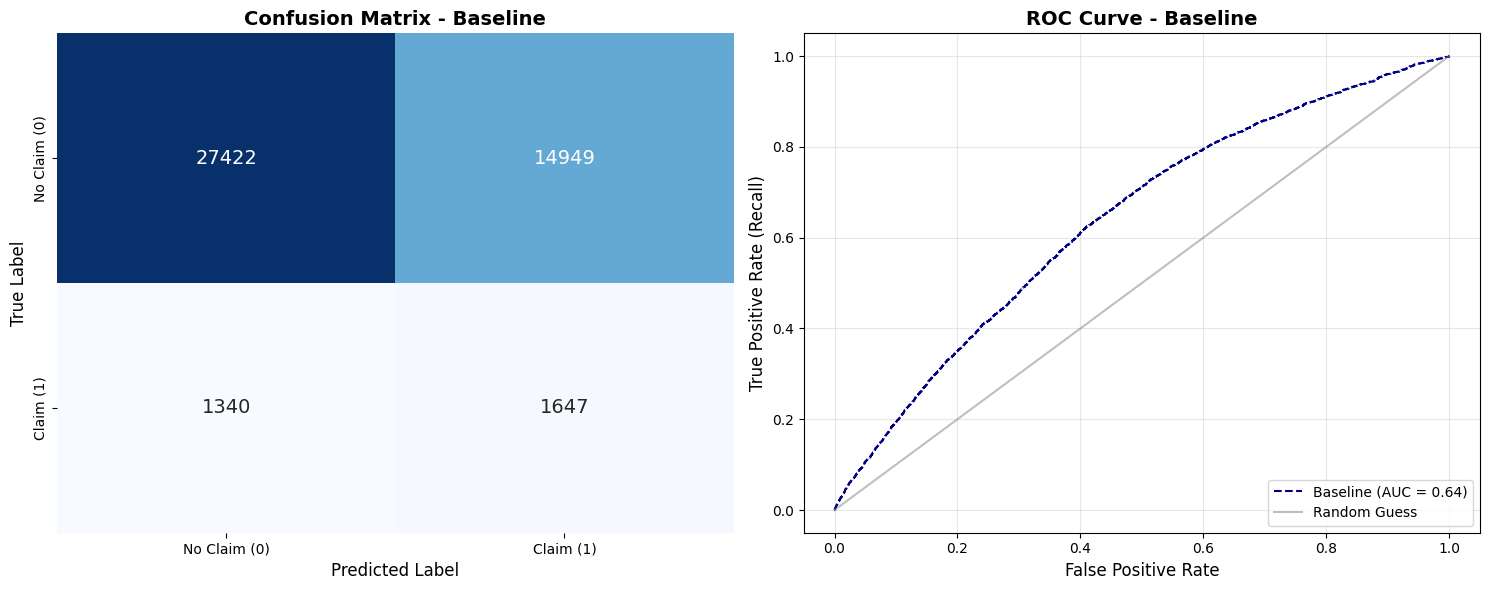

In [7]:
# random forest model
rf_model = RandomForestClassifier(
    max_depth=10, class_weight="balanced", random_state=42, n_jobs=-1
)

rf_metrics = run_baseline_analysis(rf_model, df, X.columns, "Random Forest Baseline")

Calculated imbalance ratio: 14.19
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     42371
           1       0.10      0.47      0.16      2987

    accuracy                           0.67     45358
   macro avg       0.52      0.58      0.48     45358
weighted avg       0.89      0.67      0.75     45358

XGBoost Baseline - AUC: 0.6137, Lift@10: 1.6273


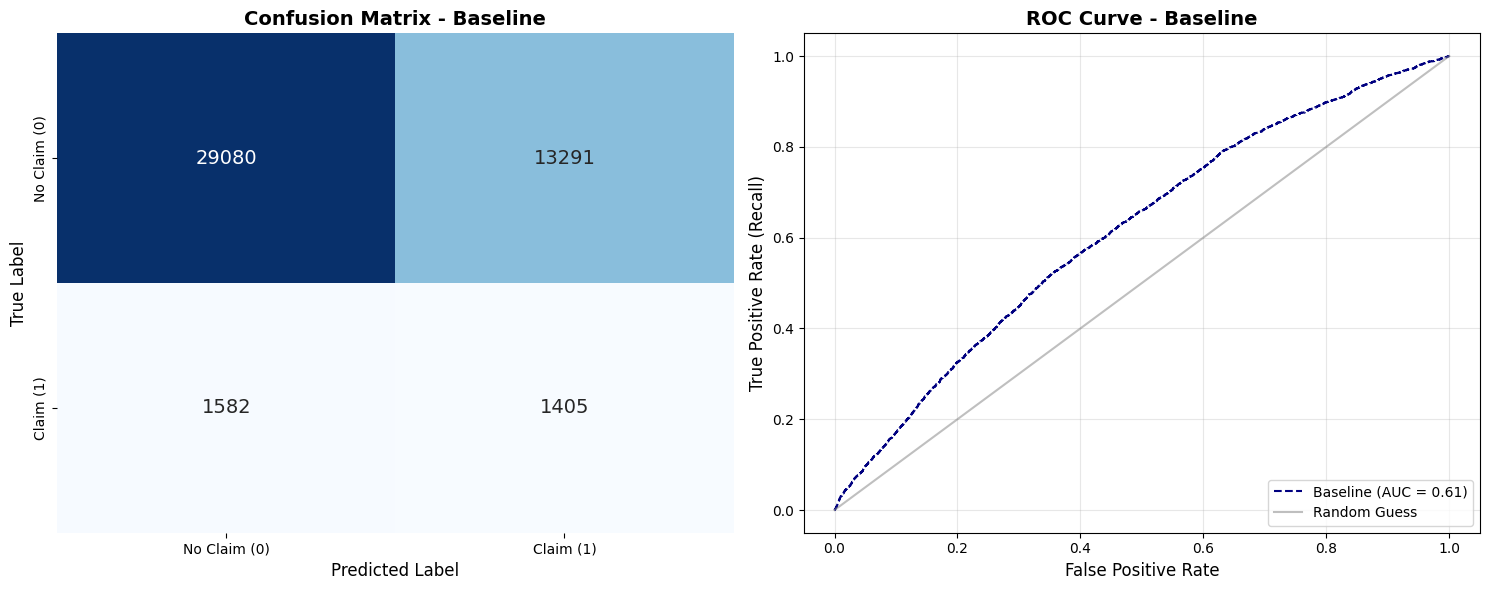

In [8]:
# Calculate the exact ratio for balancing
count_neg = (y == 0).sum()
count_pos = (y == 1).sum()
ratio = count_neg / count_pos
print(f"Calculated imbalance ratio: {ratio:.2f}")

# XGBoost Model Configuration
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=ratio, random_state=42, n_jobs=-1, eval_metric="auc"
)

# Execute
xgb_metrics = run_baseline_analysis(xgb_model, df, X.columns, "XGBoost Baseline")

              precision    recall  f1-score   support

           0       0.96      0.56      0.71     42371
           1       0.09      0.65      0.16      2987

    accuracy                           0.57     45358
   macro avg       0.53      0.60      0.44     45358
weighted avg       0.90      0.57      0.67     45358

LightGBM - AUC: 0.6388, Lift@10: 1.8082


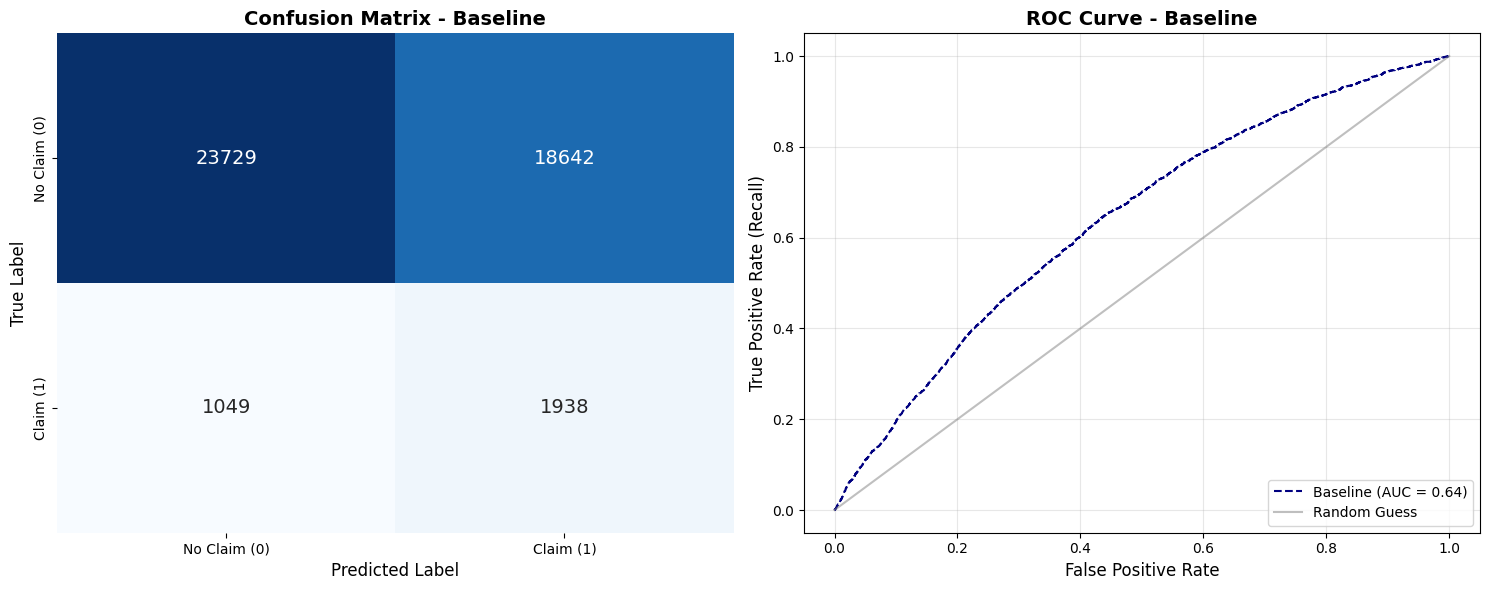

In [9]:
# LightGBM Model Configuration
lgbm_model = lgb.LGBMClassifier(
    scale_pos_weight=1.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    class_weight="balanced",
)

# Execute
lgbm_metrics = run_baseline_analysis(lgbm_model, df, X.columns, "LightGBM")

In [ ]:
# optuna hyperparameter tuning for lgbm
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",  # Maximize AUC
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": 3000,
        "random_state": 42,
        "n_jobs": -1,
        # Test from base ratio to double
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, ratio + 0.5),
        # allows leafs to specific cases
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 100),
        # regularization
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
    }

    auc_scores = []

    for fold in range(5):
        train_idx = df["kfold"] != fold
        val_idx = df["kfold"] == fold

        X_train_fold = X.loc[train_idx]
        y_train_fold = y.loc[train_idx]
        X_val_fold = X.loc[val_idx]
        y_val_fold = y.loc[val_idx]

        model = lgb.LGBMClassifier(**params)

        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]

        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric="auc",
            callbacks=callbacks,
        )

        preds = model.predict_proba(X_val_fold)[:, 1]
        auc_scores.append(roc_auc_score(y_val_fold, preds))

    # Return the average AUC across folds
    return np.mean(auc_scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("\n--- Best Configuration ---")
best_params = study.best_params

print(f"Best Average AUC (5-Fold): {study.best_value:.4f}")
print("Winning Parameters:")
print(best_params)

[I 2026-02-02 18:39:44,681] A new study created in memory with name: no-name-af513815-abb8-46f2-a766-a52dc27541af
[I 2026-02-02 18:39:46,317] Trial 0 finished with value: 0.6497084704620988 and parameters: {'scale_pos_weight': 2.201613396310961, 'min_child_samples': 89, 'learning_rate': 0.013159667419347052, 'num_leaves': 30, 'max_depth': 12, 'subsample': 0.7094693822644176, 'bagging_freq': 7, 'colsample_bytree': 0.7533438947340423, 'reg_alpha': 0.00034291229038826065, 'reg_lambda': 2.0761017419272936e-07}. Best is trial 0 with value: 0.6497084704620988.
[I 2026-02-02 18:39:47,292] Trial 1 finished with value: 0.6518650548030864 and parameters: {'scale_pos_weight': 11.817536318656861, 'min_child_samples': 85, 'learning_rate': 0.0445970298485968, 'num_leaves': 36, 'max_depth': 3, 'subsample': 0.8740370291583466, 'bagging_freq': 6, 'colsample_bytree': 0.6734371935057349, 'reg_alpha': 3.835058109500217e-07, 'reg_lambda': 0.0003294381426849026}. Best is trial 1 with value: 0.65186505480308


--- Best Configuration ---
Best Average AUC (5-Fold): 0.6525
Winning Parameters:
{'scale_pos_weight': 14.196464003918077, 'min_child_samples': 70, 'learning_rate': 0.03681776352922541, 'num_leaves': 51, 'max_depth': 3, 'subsample': 0.996184387755192, 'bagging_freq': 7, 'colsample_bytree': 0.8527164295444462, 'reg_alpha': 0.055513411691237906, 'reg_lambda': 8.814696611635949}


              precision    recall  f1-score   support

           0       0.96      0.56      0.71     42371
           1       0.10      0.66      0.17      2987

    accuracy                           0.57     45358
   macro avg       0.53      0.61      0.44     45358
weighted avg       0.90      0.57      0.67     45358

LightGBM - AUC: 0.6503, Lift@10: 1.9655


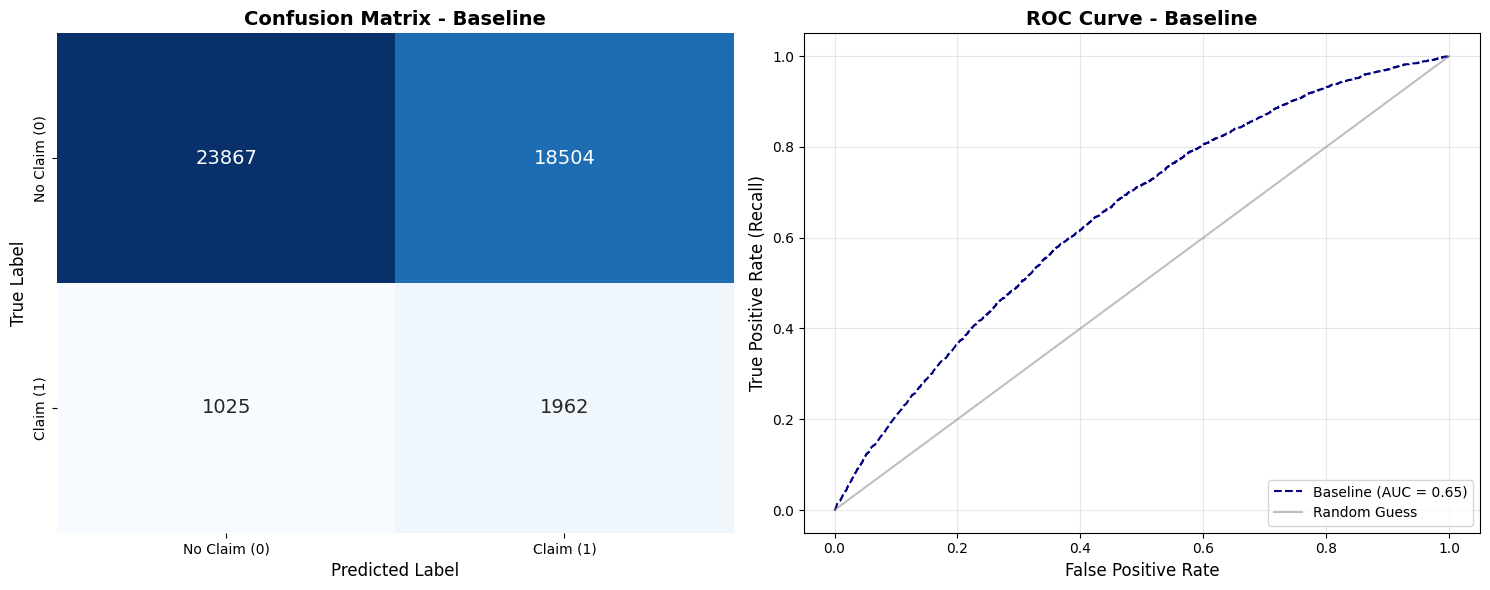

In [11]:
final_model = lgb.LGBMClassifier(**best_params)

final_metrics = run_baseline_analysis(
    final_model,
    df,
    X.columns,
    "LightGBM",
)

In [12]:
# use best params to train final model
final_params = study.best_params

# Ensure production settings
final_params["random_state"] = 42
final_params["n_jobs"] = -1
# Use a safe n_estimators based on your experience (e.g. 1000)
# or let the model use what it found if it was part of the tuning
if "n_estimators" not in final_params:
    final_params["n_estimators"] = 1000


# Train final model on full data
model_production = lgb.LGBMClassifier(**final_params)
model_production.fit(X, y)


# Packaging (Serialization)
artifact = {
    "model": model_production,
    "features": X.columns.tolist(),
}
os.makedirs(DATA_PATH / "models", exist_ok=True)
filename = DATA_PATH / "models" / "best_model_lgbm.joblib"
joblib.dump(artifact, filename)

['../data/models/best_model_lgbm.joblib']